# Multi-Agent Deep Deterministic Policy Gradients (MADDPG)
---
In this notebook, we train Unity's Tennis environment using a multi-agent DDPG algorithm.

### 1. Import the Necessary Packages

In [1]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name='Tennis_Linux_NoVis/Tennis.app', seed=1)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### Setup Actor and Critic Networks

In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model."""
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [5]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.t_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay or Prioritized Replay Memory
#        self.memory = ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, random_seed)
        self.memory = PrioritizedReplay(BATCH_SIZE, BUFFER_SIZE, random_seed, ALPHA)
    
    def step(self, state, action, reward, next_state, done, agent_number, beta):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1
        self.append_sample(state, action, reward, next_state, done, agent_number)

        # Learn, if enough samples are available in memory
        if self.memory.ready():
            if self.t_step % UPDATE_EVERY == 0:
                for _ in range(N_UPDATES):
                    experiences = self.memory.sample(beta)
                    self.learn(experiences, GAMMA, agent_number)

    def append_sample(self, state, action, reward, next_state, done, agent_number):
        """ save sample (s,a,r,s',d,e) to the prioritized experience replay memory"""
               
        self.actor_target.eval()
        self.critic_target.eval()
        self.critic_local.eval()

        state = torch.from_numpy(state).float().to(device)
        next_state = torch.from_numpy(next_state).float().to(device)
        action = torch.from_numpy(action).float().to(device)
        
        with torch.no_grad():
            # Expected next actions from Actor target network based on state
            actions_next = self.actor_target(state)

            if agent_number == 0:
                actions_next = torch.cat((actions_next, action[:,2:]), dim=1)
            elif agent_number == 1:
                actions_next = torch.cat((action[:,:2], actions_next), dim=1)
        
            # Predicted Q value from Critic target network
            Q_targets_next = self.critic_target(next_state, actions_next)
            Q_targets = reward + (GAMMA * Q_targets_next * (1 - done))

            # Actual Q value based on reward rec'd at next step + future expected reward from Critic target network
            Q_expected = self.critic_local(state, action)
            
        error = (Q_expected - Q_targets)**2
        self.memory.add(state, action, reward, next_state, done, error)

        self.critic_local.train()
        self.actor_target.train()
        self.critic_target.train()

    def act(self, states, add_noise):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        """Update policy and value parameters using given batch of experience tuples."""
        states, actions, rewards, next_states, dones, is_weight, idxs = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
                    
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        # Predicted Q value from Critic target network
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Actual Q value based on reward received at next step plus future expected rewards from Critic target network
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)

        # Update priority in PER
        loss  = (Q_expected - Q_targets).pow(2).reshape(is_weight.shape) * is_weight
        self.memory.update(idxs, loss.data.cpu().numpy())

        # Minimize critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, batch_size, buffer_size, seed):
        """Initialize a ReplayBuffer object."""
        
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def ready(self):
        """Return the current size of internal memory."""
        return len(self.memory) >= self.batch_size
    
    
class PrioritizedReplay:
    """Fixed-size buffer to store prioritized experience tuples."""

    def __init__(self, batch_size, buffer_size, seed, alpha):
        """Initialize a ReplayBuffer object."""

        self.memory = deque(maxlen=buffer_size)
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.alpha = alpha
        self.epsilon = 1e-5       
          
    def add(self, state, action, reward, next_state, done, priority):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(priority)
    
    def sample(self, beta):
        """Randomly sample a batch of experiences from memory."""
        priorities = np.array(self.priorities).reshape(-1)
        priorities = np.power(priorities + self.epsilon, self.alpha)  # add a small value epsilon to ensure numeric stability
        p = priorities/np.sum(priorities)  # compute a probability density over the priorities
        sampled_indices = np.random.choice(np.arange(len(p)), size=self.batch_size, p=p)  # choose random indices given p
        experiences = [self.memory[i] for i in sampled_indices]     # subset the experiences
        p = np.array([p[i] for i in sampled_indices]).reshape(-1)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        weights = np.power(len(experiences) * p, -beta)
        weights /= weights.max()
        weights = torch.from_numpy(weights).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, sampled_indices)

    def update(self, indices, priorities):
        """Update the priority values after training given the samples drawn."""
        for i, priority in zip(indices, priorities):
            self.priorities[i] = priority

    def ready(self):
        """Return the current size of internal memory."""
        return len(self.memory) >= self.batch_size
    

### Train The Agent

In [6]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1       # time steps between network updates
N_UPDATES = 1          # number of times training
ALPHA = 0               # PER 1 = full prioritization, 0 = no prioritization
BETA_START = 0          # PER - What degree to use importance weights (0 - no corrections, 1 - full correction)

ADD_NOISE = True
NOISE_START = 6
NOISE_END = 0
NOISE_DECAY = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)

In [7]:
print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

n_episodes = 2000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []

beta_schedule = lambda episode: min(1.0, BETA_START + episode * (1.0 - BETA_START) / n_episodes)
noise_schedule = lambda episode: max(NOISE_END, NOISE_START - episode * ((NOISE_START - NOISE_END) / NOISE_DECAY))

for i_episode in range(1, n_episodes+1):
    beta = beta_schedule(i_episode)
    eps = noise_schedule(i_episode)
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, ADD_NOISE)           # select an action (for each agent)
        action_1 = agent_1.act(states, ADD_NOISE)           # select an action (for each agent)
        actions = np.concatenate((action_0, action_1), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                         # see if episode finished
        if np.any(dones):                                   # if either agent fails, episode over
            done = True
        else:
            done = False
        agent_0.step(states, actions, rewards[0], next_states, done, 0, beta)
        agent_1.step(states, actions, rewards[1], next_states, done, 1, beta)
        scores += rewards                                  # update the score (for each agent)
        states = next_states                                # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 10 == 0:
        print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
            i_episode, np.max(scores), np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        break

print ("***FINISHED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
        

***STARTED TRAINING AT 2018-11-06--20:45:03 
Episode 10	Max Reward: 0.000	Average Reward: 0.010
Episode 20	Max Reward: 0.000	Average Reward: 0.005
Episode 30	Max Reward: 0.000	Average Reward: 0.007
Episode 40	Max Reward: 0.000	Average Reward: 0.005
Episode 50	Max Reward: 0.000	Average Reward: 0.006
Episode 60	Max Reward: 0.000	Average Reward: 0.013
Episode 70	Max Reward: 0.000	Average Reward: 0.014
Episode 80	Max Reward: 0.000	Average Reward: 0.015
Episode 90	Max Reward: 0.000	Average Reward: 0.013
Episode 100	Max Reward: 0.100	Average Reward: 0.015
Episode 110	Max Reward: 0.000	Average Reward: 0.014
Episode 120	Max Reward: 0.100	Average Reward: 0.015
Episode 130	Max Reward: 0.000	Average Reward: 0.018
Episode 140	Max Reward: 0.100	Average Reward: 0.021
Episode 150	Max Reward: 0.000	Average Reward: 0.023
Episode 160	Max Reward: 0.190	Average Reward: 0.024
Episode 170	Max Reward: 0.000	Average Reward: 0.022
Episode 180	Max Reward: 0.000	Average Reward: 0.022
Episode 190	Max Reward: 0.09

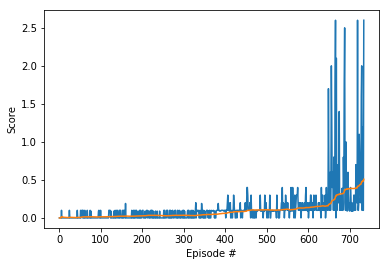

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()